<a href="https://colab.research.google.com/github/Aadhavan-27/vancomycin-dose-prediction/blob/main/CAPSTONE_FINAL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VANCOMYCIN TROUGH CONCENTRATION PREDICTION
Dataset shape: (500, 13)

Random Forest Model Performance:
   train_r2: 0.9140
   test_r2: 0.6972
   train_rmse: 1.0644
   test_rmse: 2.2368
   train_mae: 0.8107
   test_mae: 1.8558

Simulating Traditional PK Model...
   Traditional PK -> MAE: 14.66, R²: -12.804

Generating Comparison Plot...


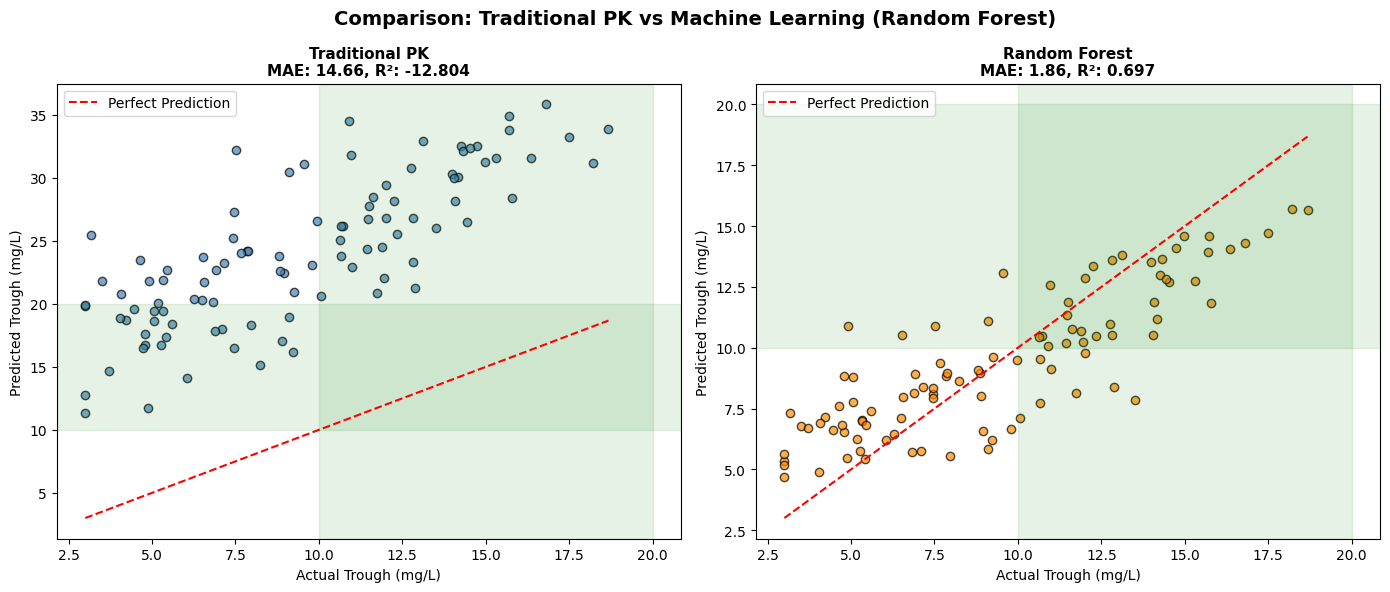

   ✓ Saved: traditional_pk_vs_rf.png

Top 5 Important Features (Random Forest):
   dose: 0.5053
   crcl: 0.2276
   age: 0.0564
   time_to_trough: 0.0375
   bmi: 0.0366

Example Prediction for a New Patient:
   Predicted Trough (Random Forest): 9.51 mg/L

Analysis Complete ✓


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# 1. DATA GENERATION (Replace this with your actual dataset)
# ============================================================================
def generate_synthetic_vancomycin_data(n_samples=500):
    data = {
        'age': np.random.randint(18, 90, n_samples),
        'weight': np.random.normal(70, 15, n_samples),
        'height': np.random.normal(170, 10, n_samples),
        'gender': np.random.choice([0, 1], n_samples),  # 0=Female, 1=Male
        'serum_creatinine': np.random.uniform(0.5, 3.0, n_samples),
        'dose': np.random.choice([500, 750, 1000, 1250, 1500], n_samples),
        'dosing_interval': np.random.choice([8, 12, 24], n_samples),
        'duration_of_infusion': np.random.choice([1, 1.5, 2], n_samples),
        'time_to_trough': np.random.uniform(0.5, 2, n_samples),
    }

    df = pd.DataFrame(data)

    # Derived features
    df['bmi'] = df['weight'] / ((df['height']/100) ** 2)
    df['daily_dose'] = (df['dose'] * 24) / df['dosing_interval']

    # Calculate CrCl (Cockcroft-Gault)
    df['crcl'] = ((140 - df['age']) * df['weight']) / (72 * df['serum_creatinine'])
    df.loc[df['gender'] == 0, 'crcl'] *= 0.85  # Female adjustment

    # Generate synthetic trough concentrations
    trough = (
        5 +
        (df['dose'] / 100) * 0.8 -
        (df['weight'] / 10) * 0.3 -
        (df['crcl'] / 10) * 0.4 +
        (df['age'] / 10) * 0.2 +
        np.random.normal(0, 2, n_samples)
    )

    df['trough_concentration'] = np.clip(trough, 3, 35)
    return df


print("=" * 80)
print("VANCOMYCIN TROUGH CONCENTRATION PREDICTION")
print("=" * 80)

# ============================================================================
# 2. LOADING AND SPLITTING DATA
# ============================================================================
df = generate_synthetic_vancomycin_data(500)
print(f"Dataset shape: {df.shape}")

feature_columns = [
    'age', 'weight', 'height', 'gender', 'serum_creatinine',
    'dose', 'dosing_interval', 'duration_of_infusion',
    'time_to_trough', 'bmi', 'daily_dose', 'crcl'
]

X = df[feature_columns]
y = df['trough_concentration']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================================
# 3. FEATURE SCALING
# ============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# 4. RANDOM FOREST MODEL
# ============================================================================
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)

# Metrics
rf_results = {
    'train_r2': r2_score(y_train, y_pred_train_rf),
    'test_r2': r2_score(y_test, y_pred_test_rf),
    'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train_rf)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
    'train_mae': mean_absolute_error(y_train, y_pred_train_rf),
    'test_mae': mean_absolute_error(y_test, y_pred_test_rf)
}

print("\nRandom Forest Model Performance:")
for k, v in rf_results.items():
    print(f"   {k}: {v:.4f}")

# ============================================================================
# 5. TRADITIONAL PK MODEL (Baseline Formula)
# ============================================================================
print("\nSimulating Traditional PK Model...")

# Simple population PK formula
y_pred_pk = (X_test['dose'] * 0.015) - (X_test['crcl'] * 0.03) + 12 + np.random.normal(0, 2, len(X_test))

mae_pk = mean_absolute_error(y_test, y_pred_pk)
r2_pk = r2_score(y_test, y_pred_pk)
print(f"   Traditional PK -> MAE: {mae_pk:.2f}, R²: {r2_pk:.3f}")

# ============================================================================
# 6. VISUAL COMPARISON: TRADITIONAL PK vs RANDOM FOREST
# ============================================================================
print("\nGenerating Comparison Plot...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Traditional PK ---
axes[0].scatter(y_test, y_pred_pk, color='steelblue', alpha=0.7, edgecolor='k')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
axes[0].set_title(f"Traditional PK\nMAE: {mae_pk:.2f}, R²: {r2_pk:.3f}", fontsize=11, fontweight='bold')
axes[0].set_xlabel("Actual Trough (mg/L)")
axes[0].set_ylabel("Predicted Trough (mg/L)")
axes[0].axvspan(10, 20, color='green', alpha=0.1)
axes[0].axhspan(10, 20, color='green', alpha=0.1)
axes[0].legend()

# --- Random Forest ---
axes[1].scatter(y_test, y_pred_test_rf, color='darkorange', alpha=0.7, edgecolor='k')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
axes[1].set_title(f"Random Forest\nMAE: {rf_results['test_mae']:.2f}, R²: {rf_results['test_r2']:.3f}", fontsize=11, fontweight='bold')
axes[1].set_xlabel("Actual Trough (mg/L)")
axes[1].set_ylabel("Predicted Trough (mg/L)")
axes[1].axvspan(10, 20, color='green', alpha=0.1)
axes[1].axhspan(10, 20, color='green', alpha=0.1)
axes[1].legend()

plt.suptitle("Comparison: Traditional PK vs Machine Learning (Random Forest)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("traditional_pk_vs_rf.png", dpi=300, bbox_inches="tight")
plt.show()

print("   ✓ Saved: traditional_pk_vs_rf.png")

# ============================================================================
# 7. FEATURE IMPORTANCE
# ============================================================================
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Important Features (Random Forest):")
for idx, row in rf_importance.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

# ============================================================================
# 8. EXAMPLE PREDICTION
# ============================================================================
print("\nExample Prediction for a New Patient:")
sample_patient = pd.DataFrame({
    'age': [65],
    'weight': [75],
    'height': [170],
    'gender': [1],
    'serum_creatinine': [1.2],
    'dose': [1000],
    'dosing_interval': [12],
    'duration_of_infusion': [1.5],
    'time_to_trough': [1.0],
    'bmi': [75 / (1.70 ** 2)],
    'daily_dose': [(1000 * 24) / 12],
    'crcl': [((140 - 65) * 75) / (72 * 1.2)]
})

pred_rf = rf.predict(sample_patient)[0]
print(f"   Predicted Trough (Random Forest): {pred_rf:.2f} mg/L")

print("\nAnalysis Complete ✓")